In [43]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

import scipy.stats.distributions as dist
import urllib
from PIL import Image
from scipy.stats import binned_statistic

In [15]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'
colors = ['r','b','g','y']

In [3]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [4]:
question = 't01_smooth_or_features'

In [5]:
def load_dataset(question,answer):
    '''Load the bin data and debiased values'''
    
    data_dir = 'output_files/{}/{}/'.format(question,answer)
    
    bins = Table.read(data_dir+'bins.fits')
    debiased = Table.read(data_dir+'debiased.fits')
    fit_results = Table.read(data_dir+'fit_results.fits')
    vbins_table = Table.read(data_dir+'vbin_parameters.fits')
    all_bins = Table.read(data_dir+'all_bins.fits')
    fit_setup = pickle.load(open(data_dir+'fit_setup.p', "rb" ))
    
    return bins,all_bins,debiased,fit_results,vbins_table,fit_setup

In [155]:
def plot_histograms(question,question_dictionary,logy=[False,False,True],normalise=False):
    
    hist_bins = np.linspace(0,1,11)
    vl_select = full_data['in_volume_limit'] == True
    low_z = (full_data['REDSHIFT_1'] > 0.03) & (full_data['REDSHIFT_1'] <= 0.035)
    high_z = (full_data['REDSHIFT_1'] > 0.08) & (full_data['REDSHIFT_1'] <= 0.085)
    
    answers = question_dictionary[question]['answers']
    labels= question_dictionary[question]['answerlabels']
    
    fig,axarr = plt.subplots(1,3,figsize=(15,4),sharex=True)
    #plt.subplots_adjust(hspace=0,wspace=0)
    
    for a,answer in enumerate(answers):
        
        if normalise == False:
            norm_fit = np.ones(len(full_data))
            norm_bin = np.ones(len(full_data))
        else:
            norm_fit = np.zeros(len(full_data))
            norm_bin = np.zeros(len(full_data))
            for A in answers:
                bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,A)
                norm_fit = norm_fit + debiased['fit_method']
                norm_bin = norm_bin + debiased['bin_method']
                
            norm_fit[np.isnan(norm_fit)] = 1
            norm_bin[np.isnan(norm_bin)] = 1
             
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        fit_data = (debiased['fit_method']/norm_fit)[(vl_select) & (high_z)]
        bin_data = (debiased['bin_method']/norm_bin)[(vl_select) & (high_z)]
        
        ref_data = full_data[question + '_' + answer + '_weighted_fraction'][(vl_select) & (low_z)]
        
        _ = axarr[a].hist(ref_data,histtype='stepfilled',color='k',alpha=0.5
                          ,normed=True,bins=hist_bins)
        _ = axarr[a].hist(bin_data,histtype='step',linewidth=2,color=colors[a],linestyle='solid'
                          ,normed=True,bins=hist_bins)
        _ = axarr[a].hist(fit_data,histtype='step',linewidth=3,color=colors[a],linestyle='dashed'
                          ,normed=True,bins=hist_bins)
        
        axarr[a].text(0.1,0.9,labels[a],ha='left',va='top',transform=axarr[a].transAxes)
        axarr[a].set_xlabel('$p$')
        if logy[a] == True:
            axarr[a].set_yscale('log')
    
    axarr[0].set_ylabel('normalised fraction')
    
    return None  

In [158]:
def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_fractions(column,bins,th=0.5):
    
    fracs = np.zeros(len(np.unique(bins)))
    
    for m,b in enumerate(np.unique(bins)):
        
        bin_data = column[bins == b]
        fracs[m] = np.sum(bin_data > th)/len(bin_data)
        
    return fracs


def plot_fractions(question,question_dictionary,p_th=0.5,normalise=False):

    vl_select = full_data['in_volume_limit'] == True
    answers = question_dictionary[question]['answers']
    labels= question_dictionary[question]['answerlabels']
    
    fig,axarr = plt.subplots(3,1,figsize=(10,10),sharex=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    
    vl_select = full_data['in_volume_limit'] == True
    
    for a,answer in enumerate(answers):
        
        if normalise == False:
            norm_fit = np.ones(len(full_data))
            norm_bin = np.ones(len(full_data))
        else:
            norm_fit = np.zeros(len(full_data))
            norm_bin = np.zeros(len(full_data))
            for A in answers:
                bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,A)
                norm_fit = norm_fit + debiased['fit_method']
                norm_bin = norm_bin + debiased['bin_method']
                
            norm_fit[np.isnan(norm_fit)] = 1
            norm_bin[np.isnan(norm_bin)] = 1
             
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        fit_data = (debiased['fit_method']/norm_fit)[vl_select]
        bin_data = (debiased['bin_method']/norm_bin)[vl_select]
        raw_data = full_data[question + '_' + answer + '_weighted_fraction'][vl_select]
        redshifts = full_data['REDSHIFT_1'][vl_select]
        
        zv,z_bins = bin_by_column(redshifts,10)
        
        raw_fracs = get_fractions(raw_data,z_bins,p_th)
        bin_fracs = get_fractions(bin_data,z_bins,p_th)
        fit_fracs = get_fractions(fit_data,z_bins,p_th)
        
        axarr[a].plot(zv,raw_fracs,linewidth=2,color=colors[a],linestyle='solid')
        axarr[a].plot(zv,bin_fracs,linewidth=2,color=colors[a],linestyle='dashed')
        axarr[a].plot(zv,fit_fracs,linewidth=2,color=colors[a],linestyle='dotted')
        
        axarr[a].set_ylabel('$f(p>{{{}}})$'.format(p_th))
        axarr[-1].set_xlabel('redshift')
        axarr[a].text(0.025,0.9,labels[a],ha='left',va='top',transform=axarr[a].transAxes)
        
    return None

In [188]:
def bin_vs_fit_scatter(question,question_dictionary):
    
    answers = question_dictionary[question]['answers']
    labels = question_dictionary[question]['answerlabels']
    fig,axarr = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    
    vl_select = full_data['in_volume_limit'] == True
    
    for a,answer in enumerate(answers):
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        redshifts = full_data['REDSHIFT_1'][vl_select]
        fit_data = debiased['fit_method'][vl_select]
        bin_data = debiased['bin_method'][vl_select]
    
        axarr[a].scatter(fit_data,bin_data,c=redshifts,cmap=plt.cm.coolwarm,lw=0,s=30,alpha=0.3)
        axarr[a].text(0.1,0.9,labels[a],ha='left',va='top',transform=axarr[a].transAxes)
    
    axarr[0].set_ylabel('$f_v(bin)$')
    for ax in axarr:
        ax.set_xlabel('$f_v(fit)$')
        
    axarr[0].axis([0,1,0,1])
    
    return None

In [247]:
def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None


def get_discrepent_galaxies(question,answer,label,p_th=0.8,p_low=0.4):
    
    fig,axarr = plt.subplots(2,4,figsize=(15,7.5))
    plt.subplots_adjust(hspace=0.01,wspace=0.01)
    
    vl_select = full_data['in_volume_limit'] == True

    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    redshifts = full_data['REDSHIFT_1']
    fit_data = debiased['fit_method']
    bin_data = debiased['bin_method']
    
    raw_column = full_data[question + '_' + answer + '_debiased']
    
    features_bin = bin_data > p_th
    features_fit = fit_data > p_th
    no_features_bin = bin_data < p_low
    no_features_fit = fit_data < p_low
    
    fit_discrepency = (features_fit) & (no_features_bin)
    bin_discrepency = (features_bin) & (no_features_fit)
    
    i = np.arange(0,len(full_data))
    url_fits = i[(fit_discrepency) & (vl_select)]
    url_bins = i[(bin_discrepency) & (vl_select)]
    
    urls = full_data['jpeg_url']
    
    for a in range(4):
        
        url_fit_i = random.choice(url_fits)
        url_bin_i = random.choice(url_bins)
        
        plt.sca(axarr[0,a])
        display_image(urls[url_fit_i],crop_in=0)
        axarr[0,a].text(0.5,0.95,'$p_{raw}=' + '{0:.2f}$'.format(raw_column[url_fit_i]),
                        transform=axarr[0,a].transAxes,color='w',ha='center',va='top')
        axarr[0,a].text(0.5,0.05,'$z=' + '{0:.2f}$'.format(redshifts[url_fit_i]),
                        transform=axarr[0,a].transAxes,color='w',ha='center',va='bottom')
        
        plt.sca(axarr[1,a])
        display_image(urls[url_bin_i],crop_in=0)
        axarr[1,a].text(0.5,0.95,'$p_{raw}=' + '{0:.2f}$'.format(raw_column[url_bin_i]),
                        transform=axarr[1,a].transAxes,color='w',ha='center',va='top')
        axarr[1,a].text(0.5,0.05,'$z=' + '{0:.2f}$'.format(redshifts[url_bin_i]),
                        transform=axarr[1,a].transAxes,color='w',ha='center',va='bottom')
    
    axarr[0,0].set_ylabel('$p_{fit} >' + '{}'.format(p_th) + ', \, p_{bin} <' + '{}$'.format(p_low))
    axarr[1,0].set_ylabel('$p_{bin} >' + '{}'.format(p_th) + ', \, p_{fit} <' + '{}$'.format(p_low))
    
    return None

# Results

Firstly, simply plot the histograms to compare the 2 methods. The grey histogram shows the low redshift raw 'control' sample (0.03 < z < 0.035). The dashed line shows the result from the fit method, and the solid line shows the equivalent result from the bin method (at 0.08 < z Z 0.085). 

The top row shows 'un-normalised' results, and the bottom row shows the same results with $\Sigma f_v = 1$:

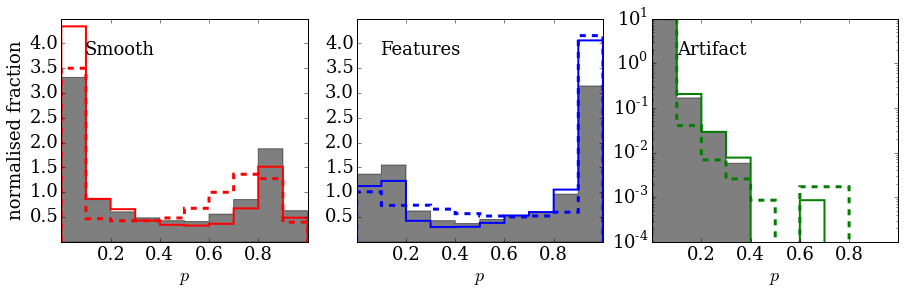

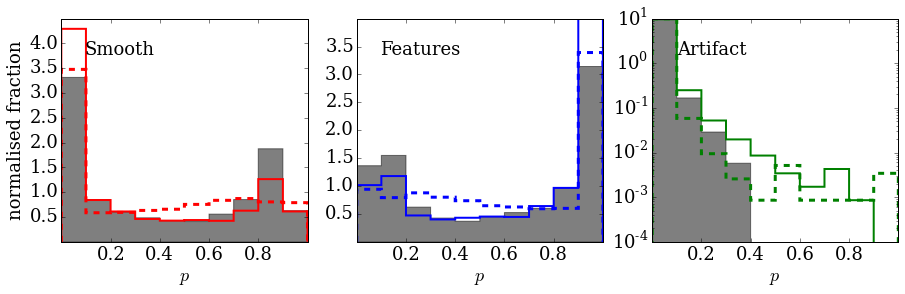

In [180]:
plot_histograms(question,questions,normalise=False)
plot_histograms(question,questions,normalise=True)

Now plot up how the fraction of galaxies above 2 different thresholds varies with $z$. We seem to do better for the fitting method overall in this case, allthough it can be seen above that the actual histogram shapes are less well fit:

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


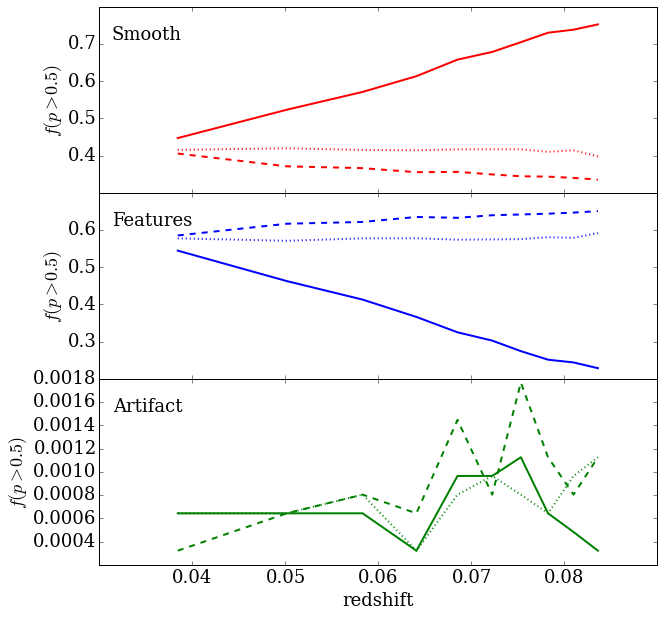

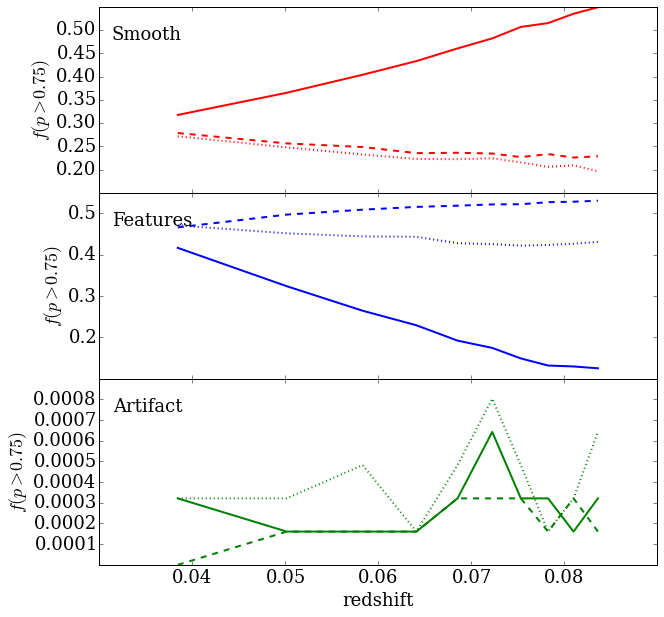

In [190]:
plot_fractions(question,questions,p_th=0.5,normalise=True)
plot_fractions(question,questions,p_th=0.75,normalise=True)

Finally, can compare the methods directly using a scatter plot of the debiased results from the 2 methods directly. Scatter points go from blue -> red with redshift:

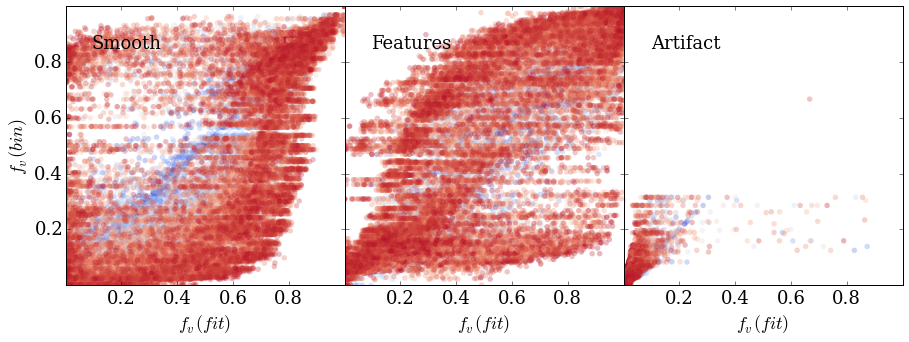

In [192]:
bin_vs_fit_scatter(question,questions)

A simple test that we can do is simply look at the 'discrepent' galaxies with 'features':

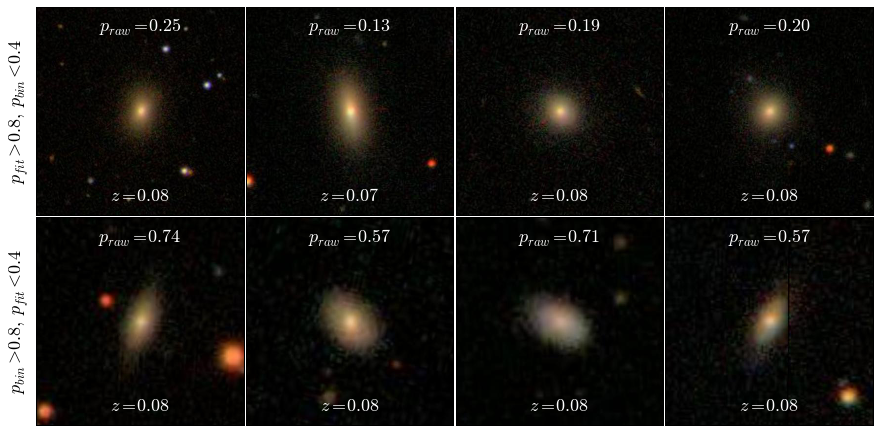

In [248]:
random.seed(0)
get_discrepent_galaxies('t01_smooth_or_features','a02_features_or_disk',label='Features')